# Clustering Crypto

In [30]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path
import altair as alt

In [31]:
# Load the cryptocurrencies data
file_path = Path("Resources/crypto_data.csv")
crypto_df = pd.read_csv(file_path, index_col=0)
crypto_df.head(10)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


### Data Preprocessing

In [32]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df=crypto_df[['CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply']]
crypto_df.head(10)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


In [33]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df["IsTrading"] == True]

In [34]:
# Keep only cryptocurrencies with a working algorithm
crypto_df = crypto_df[crypto_df["Algorithm"] != "N/A"]

In [35]:
# Remove the "IsTrading" column
crypto_df.drop("IsTrading", axis=1, inplace=True)

In [36]:
# Remove rows with at least 1 null value
crypto_df = crypto_df.dropna(axis=0, how="any")

In [37]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df["TotalCoinsMined"] > 0]

In [38]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df.iloc[:] != 'N/A'].dropna()
crypto_df.head(10)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,PoW,6.303924e+07,84000000
DASH,Dash,X11,PoW/PoS,9.031294e+06,22000000
XMR,Monero,CryptoNight-V7,PoW,1.720114e+07,0
ETC,Ethereum Classic,Ethash,PoW,1.133597e+08,210000000
ZEC,ZCash,Equihash,PoW,7.383056e+06,21000000


In [39]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coins_name = pd.DataFrame(crypto_df["CoinName"], index=crypto_df.index)
print(coins_name.shape)
coins_name.head()

(532, 1)


,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum


In [40]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop("CoinName", axis=1)
print(crypto_df.shape)
crypto_df.head(10)

(532, 4)


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0
LTC,Scrypt,PoW,6.303924e+07,84000000
DASH,X11,PoW/PoS,9.031294e+06,22000000
XMR,CryptoNight-V7,PoW,1.720114e+07,0
ETC,Ethash,PoW,1.133597e+08,210000000
ZEC,Equihash,PoW,7.383056e+06,21000000


In [41]:
# Create dummies variables for text features
X = pd.get_dummies(data=crypto_df, columns=["Algorithm", "ProofType"])
print(X.shape)
X.head(10)

(532, 98)


,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LTC,6.303924e+07,84000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DASH,9.031294e+06,22000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
XMR,1.720114e+07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETC,1.133597e+08,210000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZEC,7.383056e+06,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Standardize data
X = StandardScaler().fit_transform(X)
X[:5]

array([[-0.11710817, -0.1528703 , -0.0433963 , -0.0433963 , -0.0433963 ,
        -0.06142951, -0.07530656, -0.0433963 , -0.06142951, -0.06142951,
        -0.0433963 , -0.0433963 , -0.19245009, -0.06142951, -0.09740465,
        -0.0433963 , -0.11547005, -0.07530656, -0.0433963 , -0.0433963 ,
        -0.15191091, -0.0433963 , -0.13118084, -0.0433963 , -0.0433963 ,
        -0.08703883, -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 ,
        -0.06142951, -0.0433963 , -0.08703883, -0.08703883, -0.08703883,
        -0.0433963 , -0.13118084, -0.13840913, -0.13840913, -0.0433963 ,
        -0.06142951, -0.0433963 , -0.07530656, -0.18168574, -0.0433963 ,
        -0.0433963 , -0.0433963 , -0.07530656, -0.15826614, -0.31491833,
        -0.0433963 , -0.08703883, -0.07530656, -0.06142951,  1.38675049,
        -0.0433963 , -0.0433963 , -0.06142951, -0.0433963 , -0.0433963 ,
        -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 ,
        -0.0433963 , -0.39879994, -0.0433963 , -0.1

### Reducing Dimensions Using PCA

In [43]:
# Use PCA to reduce dimension to 3 principal components
pca = PCA(n_components=3)
df_pca = pca.fit_transform(X)
df_pca

array([[-0.34077585,  1.01415562, -0.57208822],
       [-0.32409515,  1.01430899, -0.57250511],
       [ 2.30682163,  1.74788084, -0.60673991],
       ...,
       [ 0.32457484, -2.27054017,  0.41477319],
       [-0.12693631, -2.05837372,  0.40716155],
       [-0.30016913,  0.66931093, -0.28886566]])

In [44]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(
    data = df_pca, columns = ['PC1','PC2','PC3'], index = crypto_df.index
)
pcs_df.head(10)

,PC1,PC2,PC3
42,-0.340776,1.014156,-0.572088
404,-0.324095,1.014309,-0.572505
1337,2.306822,1.747881,-0.606740
BTC,-0.144050,-1.249328,0.186987
ETH,-0.154448,-2.009371,0.388266
LTC,-0.170921,-1.171977,-0.030893
DASH,-0.377745,1.369455,-0.506279
XMR,-0.150460,-2.185808,0.430427
ETC,-0.152889,-2.009469,0.388247
ZEC,-0.126935,-2.058374,0.407162


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [45]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
alt.Chart(df_elbow).mark_line().encode(x="k", y="inertia")

alt.Chart(...)

Running K-Means with `k=<your best value for k here>`

In [46]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.concat([crypto_df, pcs_df], axis=1, sort=False)
clustered_df["CoinName"] = coins_name["CoinName"]
clustered_df["Class"] = model.labels_
print(clustered_df.shape)
clustered_df.head(10)

(532, 9)


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,CoinName,Class
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.340776,1.014156,-0.572088,42 Coin,0
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.324095,1.014309,-0.572505,404Coin,0
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.306822,1.747881,-0.606740,EliteCoin,0
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.144050,-1.249328,0.186987,Bitcoin,3
ETH,Ethash,PoW,1.076842e+08,0,-0.154448,-2.009371,0.388266,Ethereum,3
LTC,Scrypt,PoW,6.303924e+07,84000000,-0.170921,-1.171977,-0.030893,Litecoin,3
DASH,X11,PoW/PoS,9.031294e+06,22000000,-0.377745,1.369455,-0.506279,Dash,0
XMR,CryptoNight-V7,PoW,1.720114e+07,0,-0.150460,-2.185808,0.430427,Monero,3
ETC,Ethash,PoW,1.133597e+08,210000000,-0.152889,-2.009469,0.388247,Ethereum Classic,3
ZEC,Equihash,PoW,7.383056e+06,21000000,-0.126935,-2.058374,0.407162,ZCash,3


### Visualizing Results

#### 3D-Scatter with Clusters

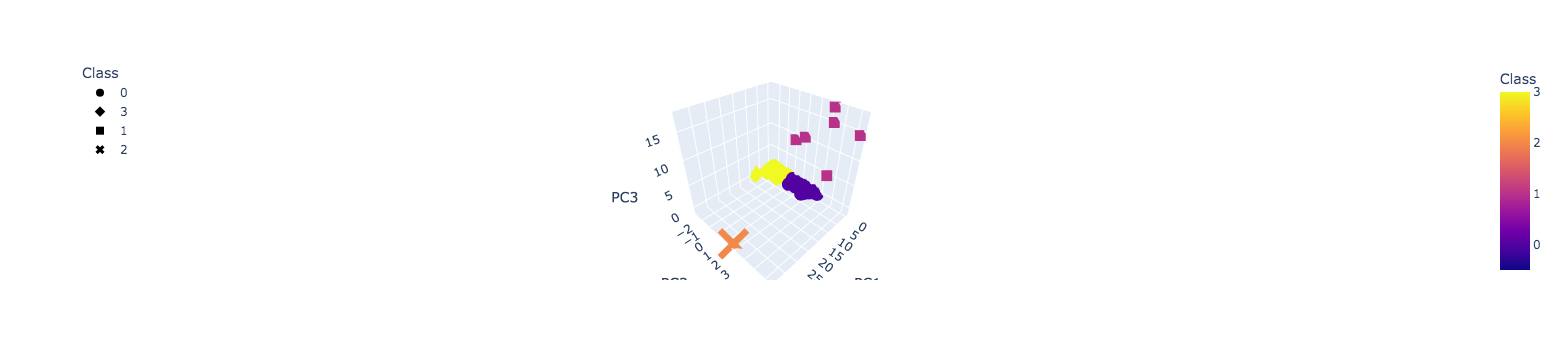

In [47]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    hover_name="CoinName",
    hover_data=["Algorithm"],
    x="PC1",
    y="PC2",
    z="PC3",
    color="Class",
    symbol="Class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [48]:
# Create a table with tradable cryptocurrencies.
clustered_df.hvplot.table(sortable=True, selectable=True)

:Table   [Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,CoinName,Class]

In [49]:
print(clustered_df.count)

<bound method DataFrame.count of         Algorithm ProofType  TotalCoinsMined TotalCoinSupply       PC1  \
42         Scrypt   PoW/PoS     4.199995e+01              42 -0.340776   
404        Scrypt   PoW/PoS     1.055185e+09       532000000 -0.324095   
1337          X13   PoW/PoS     2.927942e+10    314159265359  2.306822   
BTC       SHA-256       PoW     1.792718e+07        21000000 -0.144050   
ETH        Ethash       PoW     1.076842e+08               0 -0.154448   
...           ...       ...              ...             ...       ...   
ZEPH      SHA-256      DPoS     2.000000e+09      2000000000  2.460587   
GAP        Scrypt   PoW/PoS     1.493105e+07       250000000 -0.338820   
BDX   CryptoNight       PoW     9.802226e+08      1400222610  0.324575   
ZEN      Equihash       PoW     7.296538e+06        21000000 -0.126936   
XBC        Scrypt       PoS     1.283270e+05         1000000 -0.300169   

           PC2       PC3     CoinName  Class  
42    1.014156 -0.572088      4

#### Scatter Plot with Tradable Cryptocurrencies

In [52]:
# Scale data to create the scatter plot
mm_scaler = MinMaxScaler()
plot_data = mm_scaler.fit_transform(
    clustered_df[["TotalCoinSupply", "TotalCoinsMined"]]
)
plot_df = pd.DataFrame(
    plot_data, columns=["TotalCoinSupply", "TotalCoinsMined"], index=clustered_df.index
)
plot_df["CoinName"] = clustered_df["CoinName"]
plot_df["Class"] = clustered_df["Class"]
plot_df.head()

,TotalCoinSupply,TotalCoinsMined,CoinName,Class
42,4.200000e-11,0.000000,42 Coin,0
404,5.320000e-04,0.001066,404Coin,0
1337,3.141593e-01,0.029576,EliteCoin,0
BTC,2.100000e-05,0.000018,Bitcoin,3
ETH,0.000000e+00,0.000109,Ethereum,3


In [53]:
# Create a hvplot.scatter plot using x="TotalCoinsMined" and y="TotalCoinSupply".
plot_df.hvplot.scatter(x="TotalCoinsMined", y="TotalCoinSupply", by="Class",hover_cols = ["CoinName"])



:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)